# Limb darkening choices

`squishyplanet`'s ability to model high-order polynomial limb darkening laws gives us enormous flexibility when modeling. However, it's likely not a good idea to just fit for polynomial coefficients themselves, since you could easily end up sampling from wacky intensity profiles that don't make physical sense. Also, it'd be helpful if we could use commonly used laws besides quadratic.

The `squishyplanet.limb_darkening_laws` module provides wrappers for a few common limb darkening laws that you can use. To approximate laws that aren't actually polynomials, we first evaluate them across a dense grid of $\mu$ values, then fit a polynomial (of user-specified order) to those values. This way, we can use the polynomial to approximate the limb darkening law.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt

from squishyplanet import OblateSystem

To convert between coefficients of any of the included laws and the equivalent polynomial coefficents, we just call the function:

In [2]:
from squishyplanet.limb_darkening_laws import kipping_ld_law

kipping_ld_law(q1=0.5, q2=0.4)

Array([0.56568542, 0.14142136], dtype=float64)

If we want to visualize the intensity profile, we can add the `return_profile=True` argument to the function call. This will return a dictionary of info about the profile:

['mu_grid', 'squishyplanet_intensity_profile', 'true_intensity_profile', 'u_coeffs']


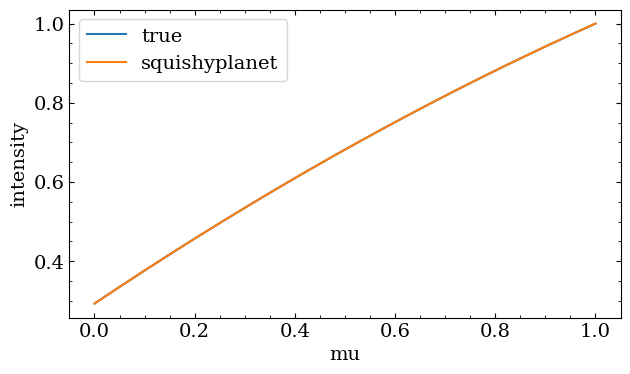

In [3]:
profile = kipping_ld_law(q1=0.5, q2=0.4, return_profile=True)
print(list(profile.keys()))

fig, ax = plt.subplots()
ax.plot(profile["mu_grid"], profile["true_intensity_profile"], label="true")
ax.plot(profile["mu_grid"], profile["squishyplanet_intensity_profile"], label="squishyplanet")
ax.legend()
ax.set(xlabel="mu", ylabel="intensity");

Since the `kipping_ld_law` is just a subset of a quadratic law, here the `squishyplanet` profile is exactly equal to the true profile. When considering a non-polynomial law however, like the `nonlinear_4param_ld_law`, we need to approximate it as a polynomial of a certain order. Here's an example of using a 5th order fit:

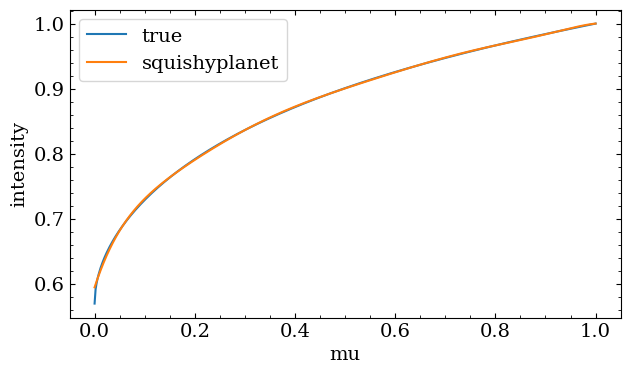

In [4]:
from squishyplanet.limb_darkening_laws import nonlinear_4param_ld_law

profile = nonlinear_4param_ld_law(u1=0.49, u2=0.13, u3=-0.32, u4=0.13, return_profile=True, order=8)
fig, ax = plt.subplots()
ax.plot(profile["mu_grid"], profile["true_intensity_profile"], label="true")
ax.plot(profile["mu_grid"], profile["squishyplanet_intensity_profile"], label="squishyplanet")
ax.legend()
ax.set(xlabel="mu", ylabel="intensity");

That's not a terrible approximation, but we can see how changing the order of the polynomial can make it better/worse:

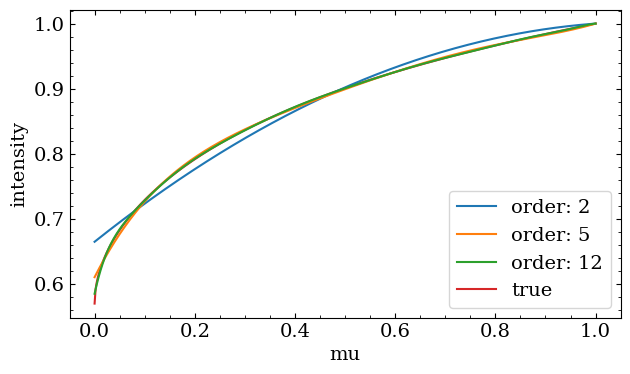

In [5]:
fig, ax = plt.subplots()

for order in [2, 5,12]:
    profile = nonlinear_4param_ld_law(u1=0.49, u2=0.13, u3=-0.32, u4=0.13, return_profile=True, order=order)
    ax.plot(profile["mu_grid"], profile["squishyplanet_intensity_profile"], label=f"order: {order}")
ax.plot(profile["mu_grid"], profile["true_intensity_profile"], label="true", zorder=-1)
ax.legend()
ax.set(xlabel="mu", ylabel="intensity");

By-eye evalutions of an intensity profile in unintuitive units like $\mu$ aren't the best way to choose our approximation order though. So, let's see the impact on the transit shape:

In [6]:
# note that since we're using different polynomial orders, we can't just reuse one
# OblateSystem object, since we need to to re-compute the Green's basis transform for
# each order and that only happens when the object is created. That means we'll have to
# recompile a bunch of times for this demo, but once you settle on an order, all future
# calls will be faster.

light_curves = []

for order in [2, 5, 12, 15]:
    state = {
        "times" : jnp.linspace(-0.5, 0.5, 300),
        "t0" : 0.0,
        "a" : 10.0,
        "period" : 5.0,
        "r" : 0.1,
        "tidally_locked" : False,
        "ld_u_coeffs" : nonlinear_4param_ld_law(u1=0.49, u2=0.13, u3=-0.32, u4=0.13, order=order)
    }

    planet = OblateSystem(**state)
    light_curves.append(planet.lightcurve())

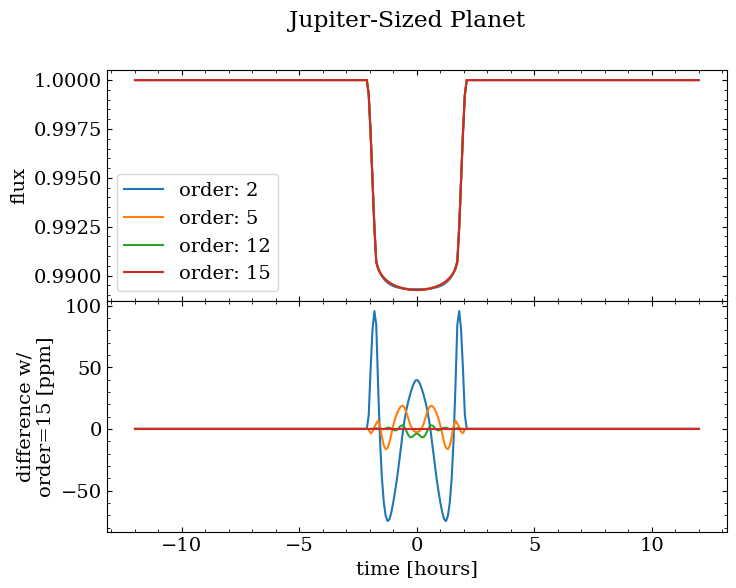

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

for i, order in enumerate([2, 5, 12, 15]):
    ax[0].plot(jnp.linspace(-0.5, 0.5, 300)*24, light_curves[i], label=f"order: {order}")
    ax[1].plot(jnp.linspace(-0.5, 0.5, 300)*24, (light_curves[i] - light_curves[-1])*1e6, label=f"order: {order}")
ax[0].legend()
ax[0].set(ylabel="flux")
ax[1].set(xlabel="time [hours]", ylabel="difference w/\norder=15 [ppm]")
fig.suptitle("Jupiter-Sized Planet")
fig.subplots_adjust(hspace=0)

We can see that for this particular Hot Jupiter-like system, our quadratic approximation introduces a roughly 100 ppm error compared to a higher-order fit. That's enough to bias an oblateness measurement, which is based off a comparably sized signal. At 5th order we get down to 10s of ppm, and it shrinks towards convergence with increasing order. By default, `squisyplanet` uses a 12th order polynomial to approximate the intensity profile (again though, for any polynomial law, it uses the exact coefficients).

Note that if we go much higher than 15th order we start to run into numerical stability issues, so it's probably not a good idea to go much higher than that.

Note also that the difference scales with planet radius: a Neptune-sized fares much better with a low-order fit:

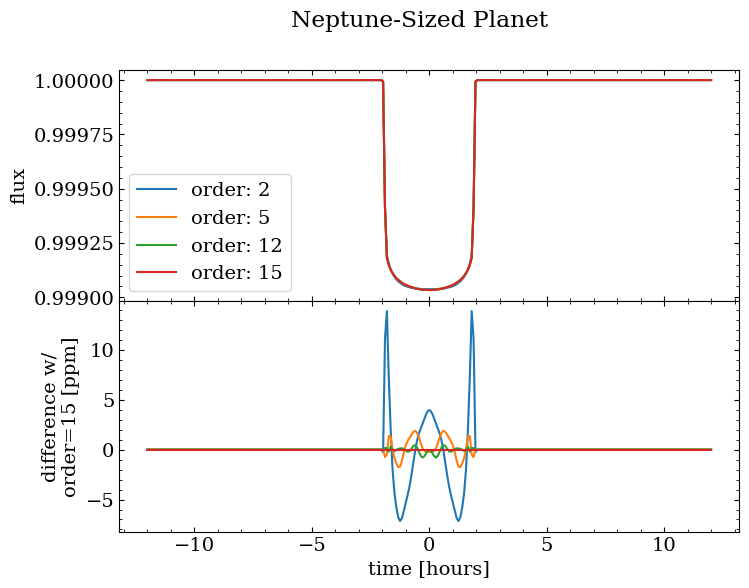

In [8]:
light_curves = []

for order in [2, 5, 12, 15]:
    state = {
        "times" : jnp.linspace(-0.5, 0.5, 300),
        "t0" : 0.0,
        "a" : 10.0,
        "period" : 5.0,
        "r" : 0.03,
        "tidally_locked" : False,
        "ld_u_coeffs" : nonlinear_4param_ld_law(u1=0.49, u2=0.13, u3=-0.32, u4=0.13, order=order)
    }

    planet = OblateSystem(**state)
    light_curves.append(planet.lightcurve())

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

for i, order in enumerate([2, 5, 12, 15]):
    ax[0].plot(jnp.linspace(-0.5, 0.5, 300)*24, light_curves[i], label=f"order: {order}")
    ax[1].plot(jnp.linspace(-0.5, 0.5, 300)*24, (light_curves[i] - light_curves[-1])*1e6, label=f"order: {order}")
ax[0].legend()
ax[0].set(ylabel="flux")
ax[1].set(xlabel="time [hours]", ylabel="difference w/\norder=15 [ppm]")
fig.suptitle("Neptune-Sized Planet")
fig.subplots_adjust(hspace=0)

Check out the `limb_darkening_laws` documentation for more info on the included laws and how to use them!